# Warmup: spot detection with napari


### Overview
In this activity, we will perform spot detection on some in situ sequencing data ([Feldman and Singh et al., Cell, 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)31067-0s)). The goal is to familiarze you with performing analysis that integrates the scientific python ecosystem and napari.

### Data source

The data were downloaded from [OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

### Next steps

We will use the workflow generated in this activity to create a napari spot detection plugin. 

In [1]:
%gui qt

# Load the data

In the cells below load the data using the scikit-image `imread()` function. For more information about the `imread()` function, please see the [scikit-image docs](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread). We are loading two images:

- `nuclei`: an image of cell nuclei
- `spots`: an image of in situ sequencing spots

In [2]:
from skimage import io

nuclei = io.imread('./data/nuclei.tif')
spots = io.imread('./data/spots.tif')

# View the data

We will use napari to view our data. To do so, we first must create the viewer. Once the Viewer is created, we can add images to the viewer via the Viewer's `add_image()` method. 

In [3]:
import napari

# create the napari viewer
viewer = napari.Viewer();

# add the nuclei image to the viewer
viewer.add_image(nuclei);


2021-06-21 08:43:11,289 [INFO] WRITING LOG OUTPUT TO /Users/kyamauch/.cellpose/run.log


In the cell below, add the spots image to the viewer as was done above for the nuclei image. After loading the data, inspect it in the viewer and adjust the layer settings to your liking (e.g., contrast limits, colormap).

In [4]:
# add the spots image to the viewer
viewer.add_image(spots)


<Image layer 'spots' at 0x7f8a3f1cf340>

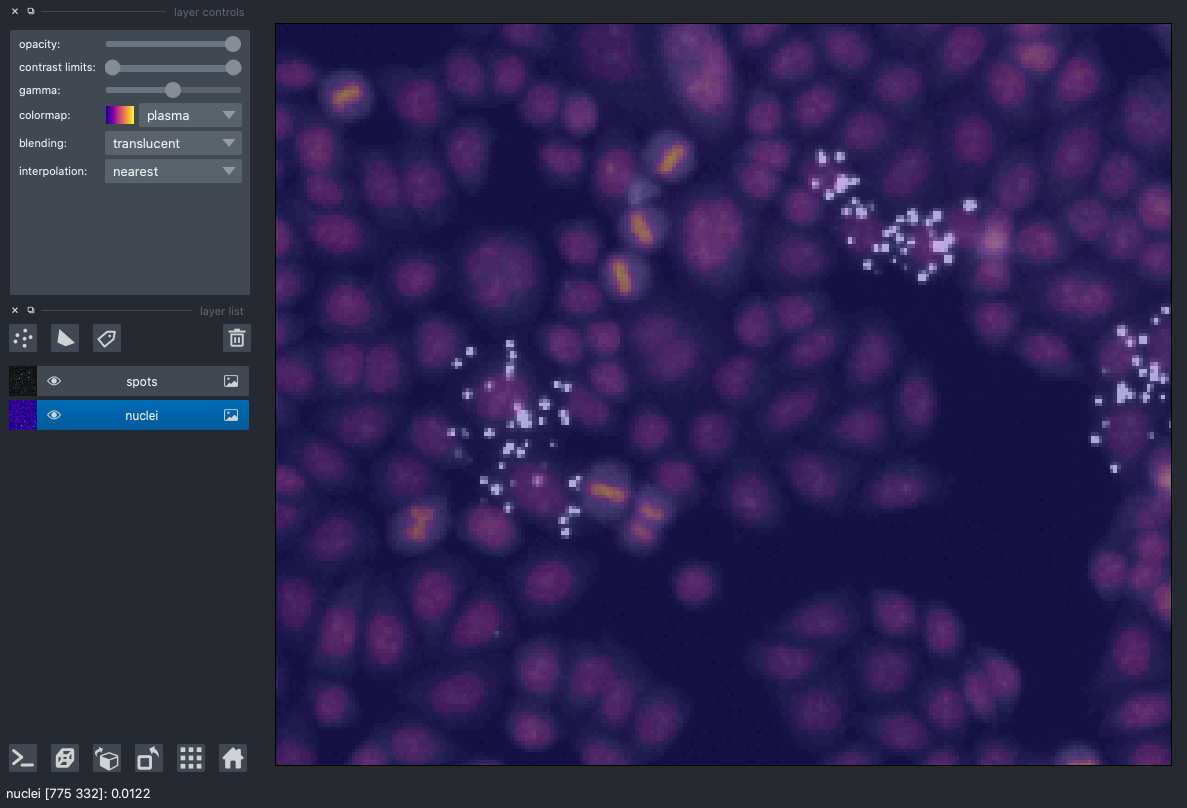

In [6]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

# Create an image filter

You may have noticed the the spots image contains background and autofluorescence from the cells. To improve spot detection, we will apply a high pass filter to improve the contrast of the spots.

In [7]:
import numpy as np
from scipy import ndimage as ndi

def gaussian_high_pass(image: np.ndarray, sigma: float = 2):
    """
    Apply a gaussian high pass filter to an image.

    Parameters
    ----------
    image : np.ndarray
        The image to be filtered.
    sigma : float
        The sigma (width) of the gaussian filter to be applied.
        The default value is 2.
    
    Returns
    -------
    high_passed_im : np.ndarray
        The image with the high pass filter applied
    """
    low_pass = ndi.gaussian_filter(image, sigma)
    high_passed_im = image - low_pass
    
    return high_passed_im

In the cell below, apply the gaussian high pass filter to the `spots` image and add the image to the viewer.

In [10]:
# Use the gaussian_high_pass function to filter the spots image
filtered_spots = gaussian_high_pass(spots, 2)

# add the filtered image to the viewer
viewer.add_image(filtered_spots, opacity=0.6)

<Image layer 'filtered_spots' at 0x7fb7ccc26bb0>

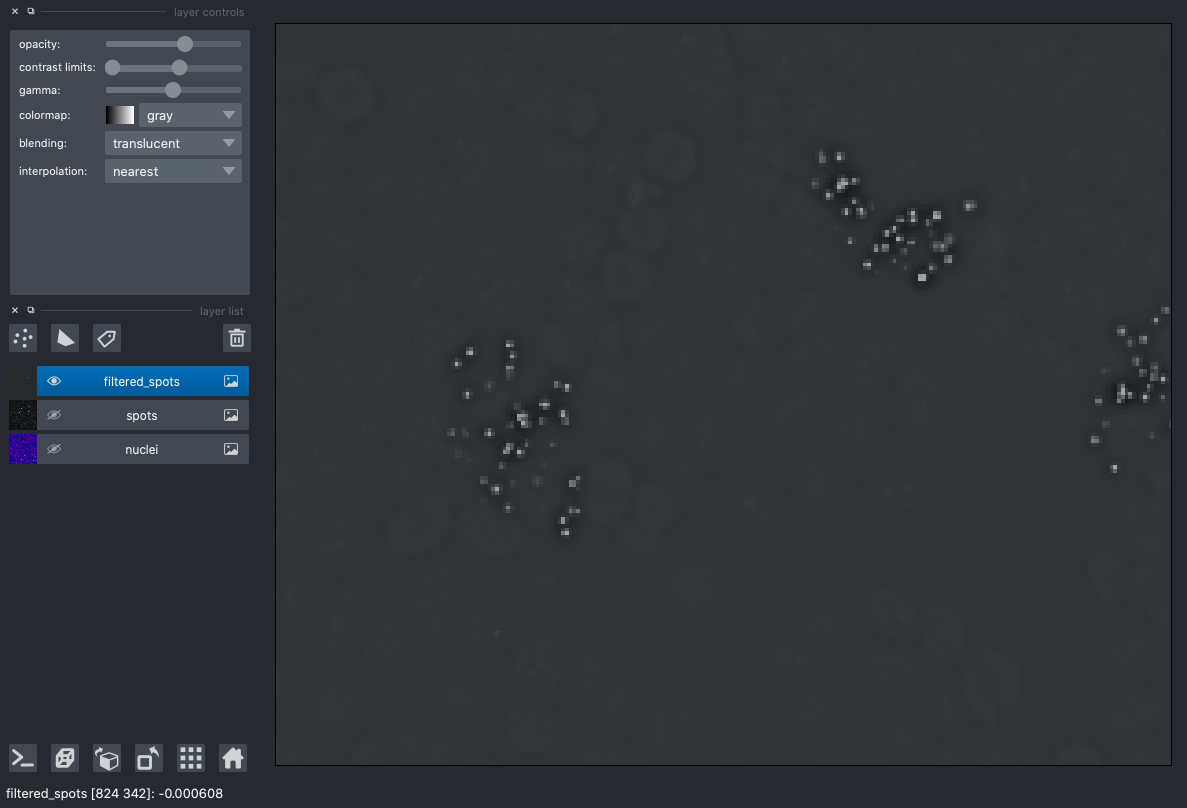

In [11]:
nbscreenshot(viewer)

# Detect spots

Create a function using the stub below to detect spots.

In [12]:
from skimage.feature import blob_log

def detect_spots(
    image,
    high_pass_sigma: float = 2,
    spot_threshold: float = 0.01,
    blob_sigma: float = 2
):
    """"""
    # filter the image
    filtered_spots = gaussian_high_pass(image, high_pass_sigma)

    # detect the spots
    blobs_log = blob_log(
        filtered_spots,
        max_sigma=blob_sigma,
        num_sigma=1,
        threshold=spot_threshold
    )
    points_coords = blobs_log[:, 0:2]
    sizes = 3 * blobs_log[:, 2]

    return points_coords, sizes

In [13]:
spot_coords, spot_sizes = detect_spots(spots)
viewer.add_points(spot_coords, size=2, symbol='ring')

<Points layer 'spot_coords' at 0x7fb7cd797e20>

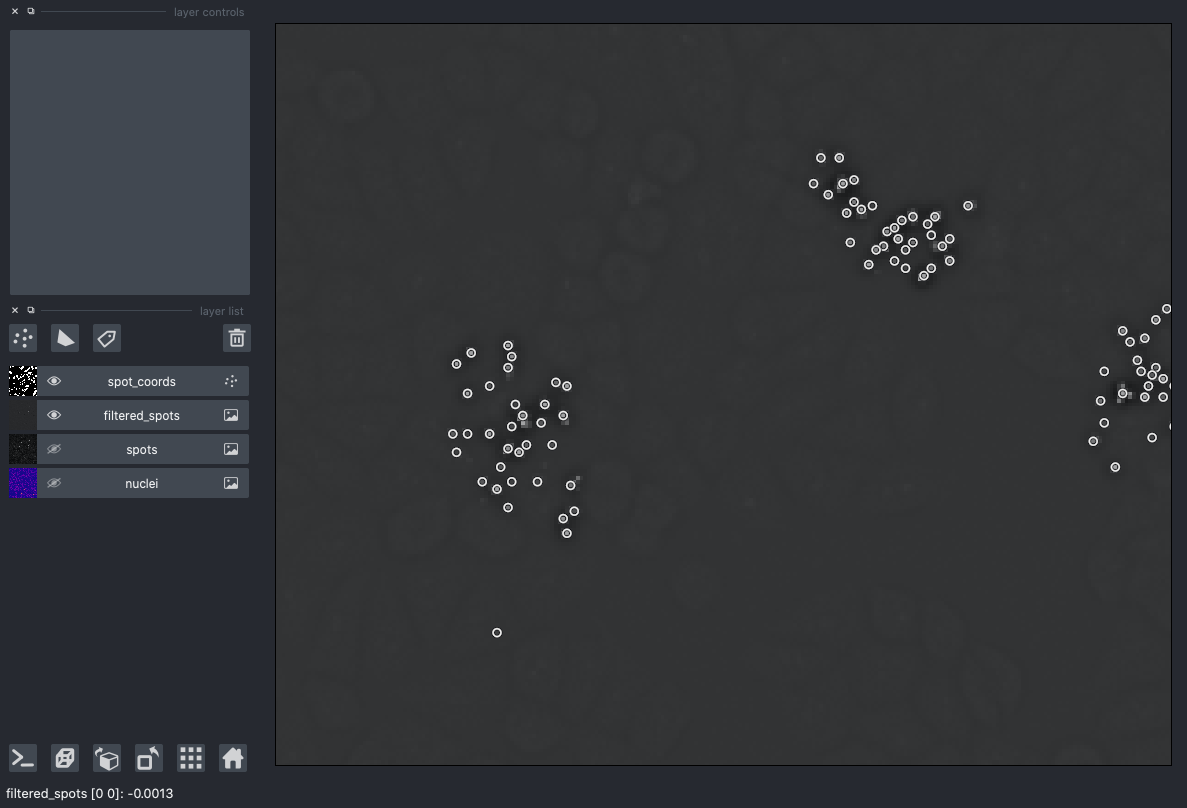

2021-06-14 17:50:39,216 [INFO] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
2021-06-14 17:50:46,548 [INFO] computed diameter = 10.041963861706277
2021-06-14 17:50:56,817 [INFO] nuclei
2021-06-14 17:50:56,818 [INFO] spots
2021-06-14 17:50:56,819 [INFO] filtered_spots
2021-06-14 17:50:56,821 [INFO] spot_coords
2021-06-14 17:50:56,822 [INFO] Shapes
(1024, 1024)
2021-06-14 17:50:56,835 [INFO] computing masks with cellprob_threshold=0.0, flow_threshold=0.4
2021-06-14 17:50:56,836 [INFO] >>nuclei<< model set to be used
2021-06-14 17:50:56,837 [INFO] TORCH CUDA version not installed/working.
2021-06-14 17:50:56,838 [INFO] >>>> using CPU


In [14]:
nbscreenshot(viewer)

# Segment nuclei

To segment the nuclei, we will use the [cellpose napari plugin](https://github.com/MouseLand/cellpose-napari). For 
more information on cellpose, please see the [paper](https://www.nature.com/articles/s41592-020-01018-x) and [repository](https://github.com/MouseLand/cellpose).

\<Step by step instructions on using cellpose\>

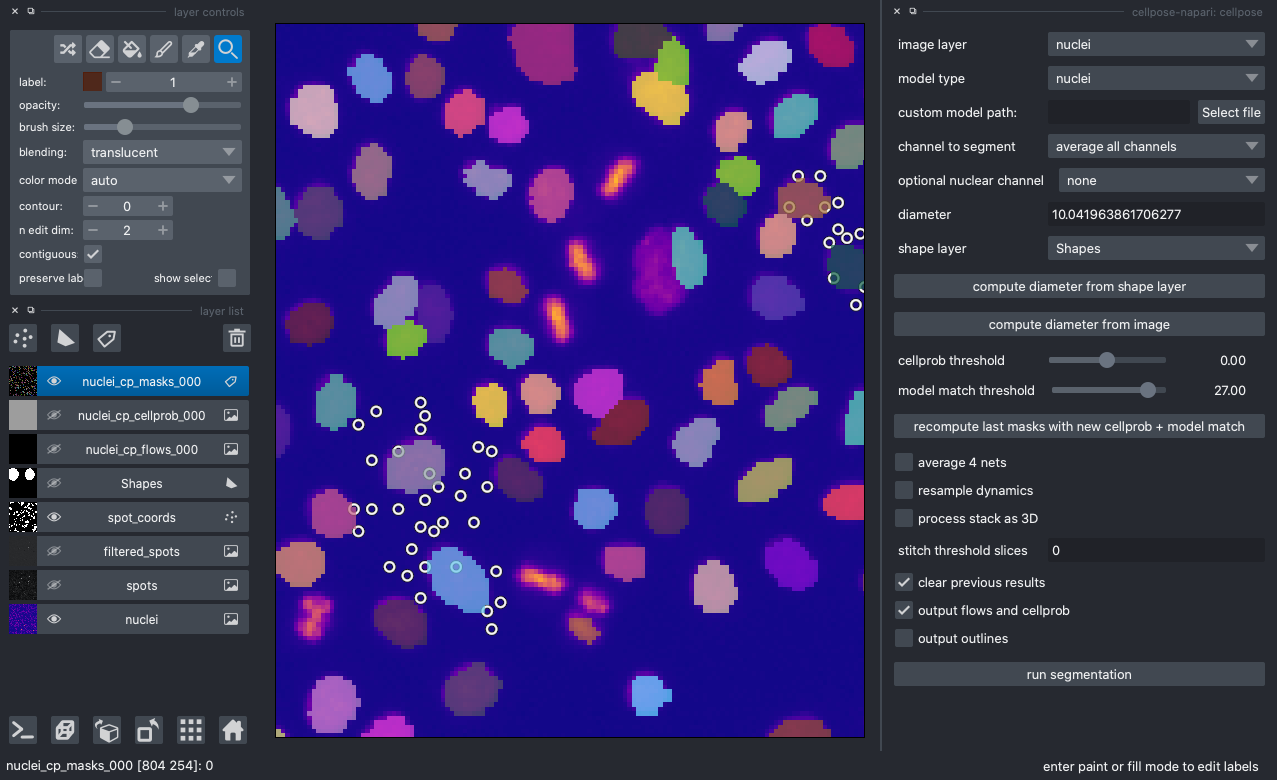

In [15]:
nbscreenshot(viewer)

In [16]:
# get the nuclei masks from the output of cellpose
nuclei_labels = viewer.layers['nuclei_cp_masks_000'].data

# Assign detected spots to cells

In this step, we will assign the detected spots to the nearest nucleus.


### Step 1: get the locations of the nuclei
First, use regionprops_table to find the centroids of all detected nuclei. Then, create an N x 2 numpy array containing the coordinate of the centroid of each nucleus. You can visualize the coordinates in a Points layer to verify they are correct.

In [17]:
from skimage.measure import regionprops_table

rp_table = regionprops_table(
    nuclei_labels,
    properties=('label', 'centroid')
)

nuclei_centroids = np.column_stack(
    (rp_table['centroid-0'], rp_table['centroid-1'])
)
viewer.add_points(nuclei_centroids, size=5)

<Points layer 'nuclei_centroids' at 0x7fb7cd7ac130>

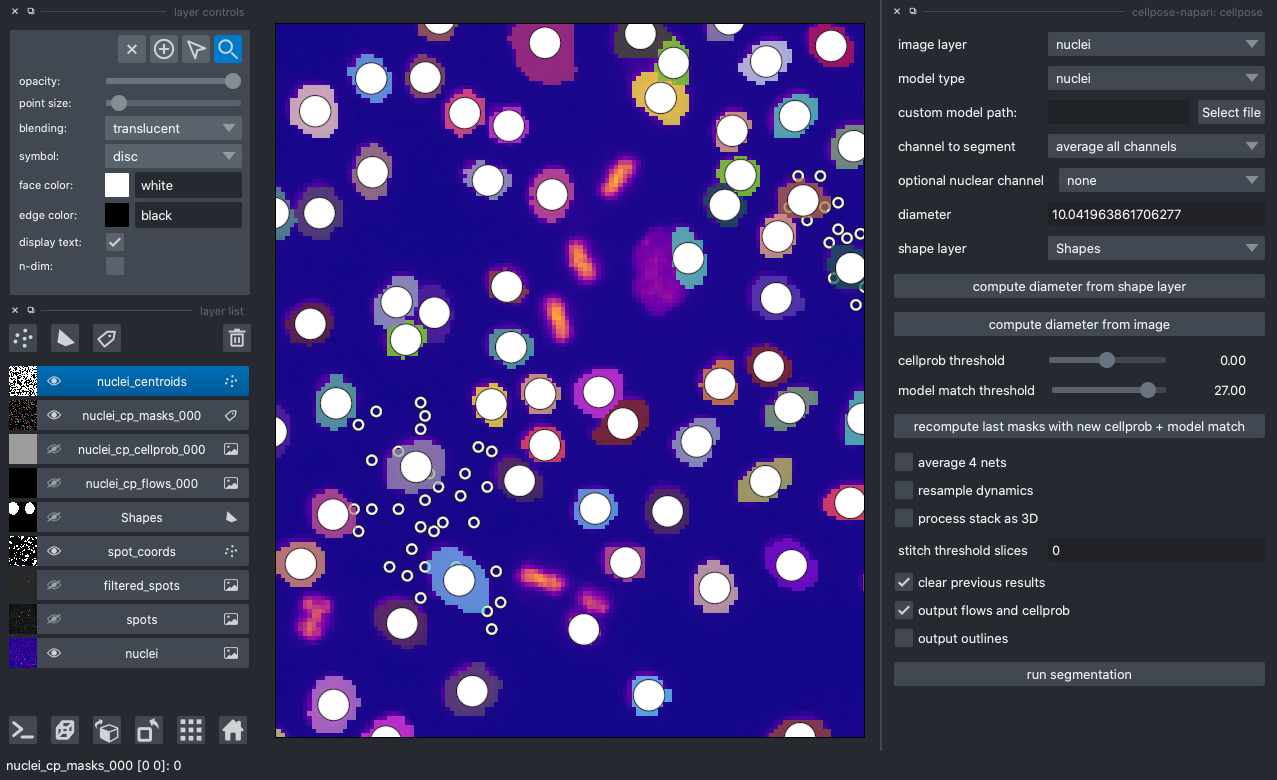

In [18]:
nbscreenshot(viewer)

### Step 2: Find the nearest nucleus for each spot

In this step, we will use a KDTree to quickly determine which nucleus each spot is closest to.

In [19]:
from scipy.spatial import cKDTree

kdt = cKDTree(nuclei_centroids)

# query kdtree to get the nearest nucleus for each detected spot
_, nearest_nucleus_ind = kdt.query(spot_coords, k=1)

# convert the index to label value in the segmentation image
nucleus_label_values = rp_table['label']
nearest_nucleus_label = nucleus_label_values[nearest_nucleus_ind]

### Step 3: visualize the results



In [20]:
unique_labels = np.unique(nearest_nucleus_label)

nuc_labels_layer = viewer.layers['nuclei_cp_masks_000']
nuc_colormap = {
    l:nuc_labels_layer.get_color(l) for l in unique_labels
}


In [21]:
spot_properties = {'nucleus_label': nearest_nucleus_label}
face_color = {
    'colors': 'nucleus_label',
    'color_mode': 'cycle',
    'categorical_colormap': nuc_colormap
}
pts = viewer.add_points(
    spot_coords,
    properties=spot_properties,
    face_color=face_color,
    symbol='ring',
    size=2
)

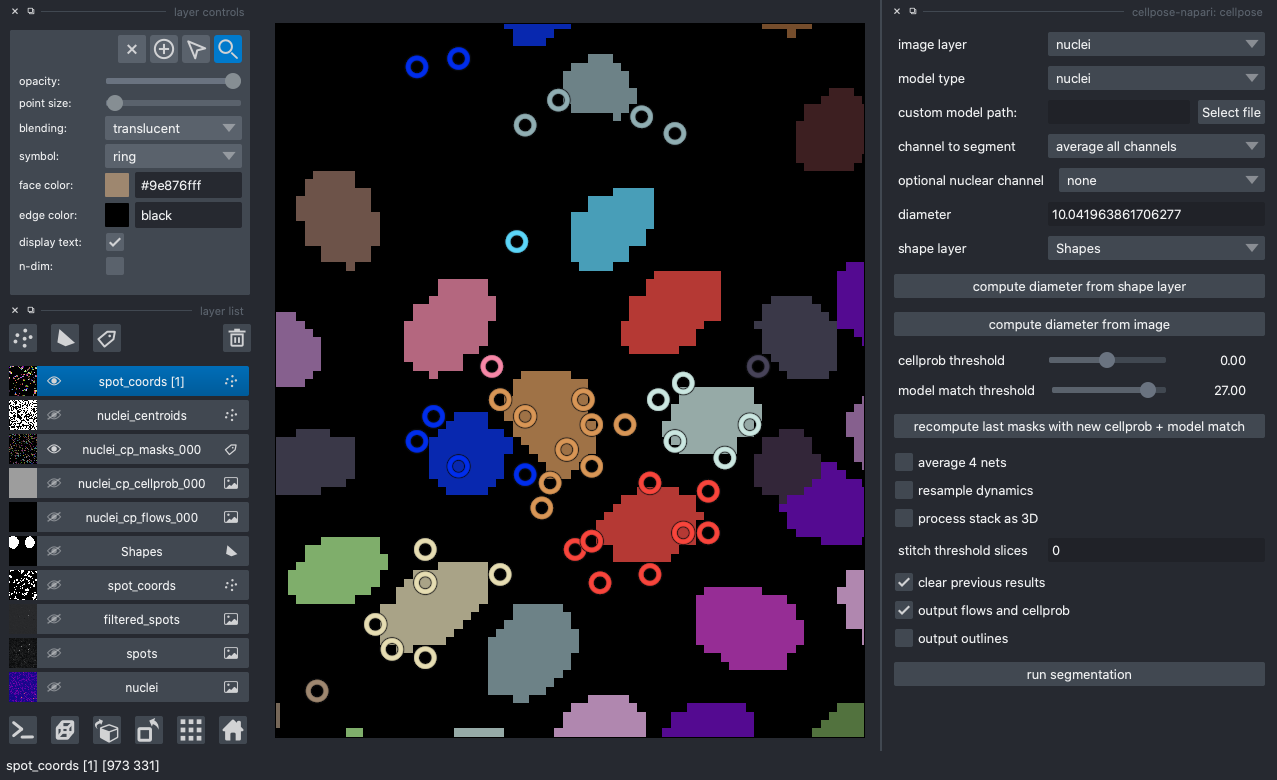

In [22]:
nbscreenshot(viewer)